In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
DEBUG = False

PI = np.pi

### Define the base functions

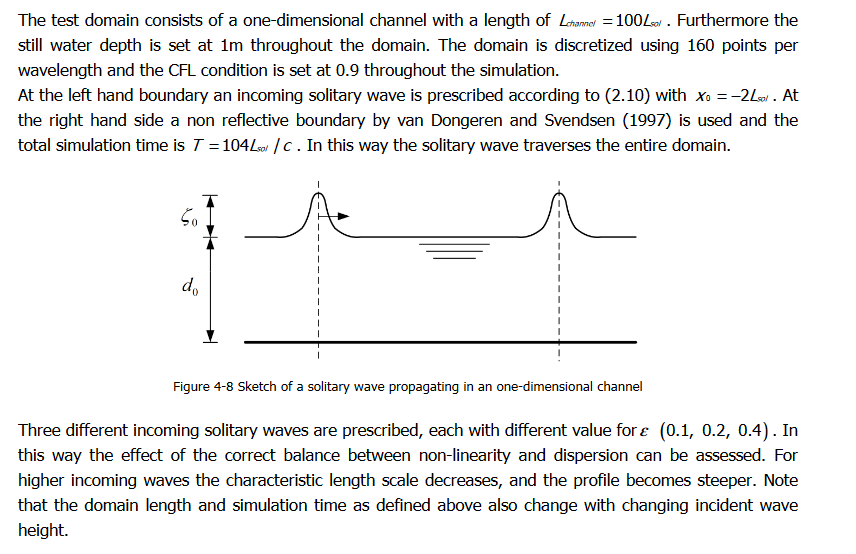

### Define the model parameters

The bottom of the geometry is flat.

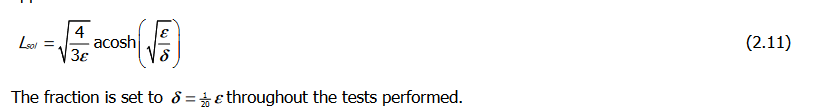

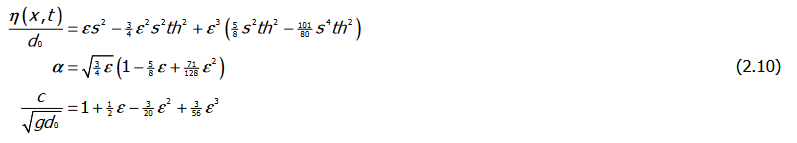

In [129]:
def calc_alpha(epsilon):
    r"""
    Purpose: Calc the alpha term in equation 2.10 of non-hyrdostatic model
    \alpha = \sqrt{\frac{3}{4} \epsilon} (1 - \frac{5}{8} \epsilon + \frac{71}{128} \epsilon^{2})
    """
    
    alpha = np.sqrt(3/4 * epsilon) * (1 - 5/8 * epsilon + 71/128 * epsilon**2)

    return alpha

def calc_wave_speed(g, epsilon, d0):
    r"""
    Purpose: Calc the wave speed
    c = (1 + \frac{1}{2} \varepsilon - \frac{3}{20} \varepsilon^{2} + frac{3}{56} \varepsilon^{3}) * \sqrt{g d_{0}}
    """

    c = (1 + 1/2 * epsilon - 3/20 * epsilon**2 + 3/56 * epsilon**3) * np.sqrt(g * d0)

    return c

def sech(x):
    """
    Purpose: Calc sech, numpy doesn't have the in-built function 
    """

    return 1/np.cosh(x)

def calc_s_term(alpha, x, x0, c, t, d0):
    r"""
    Calc the s term in the Fenton (1972) paper

    Eqn:
        s = sech(\alpha x_{*})

    where:
        \alpha: Is an input parameter
        x_{*}: dimensionless x location - x_{*} = x/d0
    
    The equation was modified to account for reference systems that are fixed by xBeach Non-Hydrostatic manual
    The new equation takes the form
    Eqn:
        s = sech(\alpha * (x - x_{0} - c t) * 1/d0)
    
    NOTE: The 1/d0 isn't included in the Non-Hydrostatic manual but I don't think that matters since the water depth is 1
    where:
        x    : the x-location
        x_{0}: the arbitrary intial location
        c    : The wave speed
        t    : time
        d0   : Water depth
    """

    return sech(alpha * ( x - x0 - c * t) * 1/d0)

def calc_th_term(alpha, x, x0, c, t, d0):
    r"""
    Calc the "th" term (as referred to as from the xBeach manual) refrerred to as the "t" term in Fenton (1972)

    From Fenton the original equation is
    Eqn:
        th = tanh(\alpha x_{*})
    
    NOTE: The 1/d0 isn't included in the Non-Hydrostatic manual but I don't think that matters since the water depth is 1
    where:
        \alpha: Is an input parameter
        x_{*} : dimensionless x-location - x_{*} = x/d0

    The equation was modified for reference coordinate systems that are fixed by the xBeach Non-Hydrostatic manual
    The new equaiton takes the form
    Eqn:
        th = tanh(\alpha * (x - x_{0} - c t) * 1/d0)
    """

    return np.tanh(alpha * ( x - x0 - c * t) * 1/d0)

def calc_surface_elevation(epsilon, x0, x, t, g, d0):
    r"""
    Purpose: Calc the normalized surface elevation for a solitary wave
    
    \eta(x,t) = d_0 \left( \varepsilon s^2 - 
                \frac{3}{4}\varepsilon^2 s^2 th^2 
                + \varepsilon^3 \left( \frac{5}{8} s^2 th^2 
                - \frac{101}{80} s^4 th^2 \right) \right)

    Variables:
    epsilon: ratio of wave height to water depth
    x0: Initial location of the wave
    x: wave height at certain location
    t: time
    g: gravity
    d0: Initial water depth
    """

    # Calc the wave speed
    c = calc_wave_speed(g, epsilon, d0)

    # Calc alpha
    alpha = calc_alpha(epsilon)

    # Calc the s term
    s = calc_s_term(alpha, x, x0, c, t, d0)
    # calc the th term

    th = calc_th_term(alpha, x, x0, c, t, d0)

    # Calc each term in the equation seperately to make reading easier
    
    # NOTE: This is Fenton's first term
    # This makes the water level at d0
    first_term = 1 + epsilon * s**2 

    # NOTE: This is xBeach non-hydro manual solution
    # This makes the water level at zero
    # first_term  = epsilon * s**2

    second_term = -3/4 * epsilon**2 * s**2 * th**2
    third_term  = epsilon**3 * (5/8 * s**2 * th**2 -101/80 * s**4 * th**2)

    # Sum the terms with the correct sign and multiply by the d0 scaling
    eta = (first_term + second_term + third_term) * d0

    if DEBUG:
        print("Printing surface elevation info")
        print("s", s)
        print("th", th)
        print(eta)

    return eta

def calc_L_scaling(epsilon, delta_scaling = 1/20):
    r"""
    Purpose: Calc the wave length scaling parameter
    L_{sol} = \sqrt{\frac{4}{3 \varepsilon} * acosh(\frac{\varepsilon}{\delta})}

    Variables:
    epsilon: Ratio of intial wave height to intial depth
    delta_scaling: Scaling of epsilon terms used to calc delta - taken tobe 1/20 in the manual
    """

    delta = delta_scaling * epsilon # Ratio set in the paper

    L_sol = np.sqrt(4/(3 * epsilon)) * np.arccosh(np.sqrt(epsilon/delta))

    return L_sol

def calc_u_vel(epsilon, x0, x, y, t, g, d0):
    r"""
    Calc the u velocity using the third order accurate soln. from Fenton (1972)
    
    Fenton (1972) DOI: 10.1017/S002211207200014X

    Eqn:
        u = { 
                1 + 1/2 \epsilon - 3/20 \epsilon^{2} 
                + 3/56 \epsilon^{3} - \epsilon * s^{2}
                + \epsilon^{2} [ -1/4 s^{2} + s^{4} + y^{2} (3/2 s^{2} - 9/4 s^{4})]
                + \epsilon^{3} [19/40 s^{2} + 1/5 s^{4} - 6/5 s^{6} 
                + y^{2} (-3/2 s^{2} - 15/4 s^{4} + 15/2 s^{6})
                + y^{4} (-3/8 s^{2} + 45/16 s^{4} - 45/16 s^{6})]
            } \sqrt(g h)
        
        with:
        s = sech ( \alpha x)

    where
        - x: x-location
        - y: y-location
        - epsilon: Selection expansion factor
        - g: gravity
        - h: inital water depth

    NOTE: The co-ordinate orign is at a point on the rigid bottom with x in the direction of flow
    NOTE: s and th are shifted from Fentons solution to account for a stationary co-ordinate system
    """
    
    # Calc the wave speed
    c = calc_wave_speed(g, epsilon, d0)

    # Calc alpha
    alpha = calc_alpha(epsilon)

    # Calc the s term
    s  = calc_s_term(alpha, x, x0, c, t, d0)

    # calc the th term
    th = calc_th_term(alpha, x, x0, c, t, d0)
    
    # Calc the terms of the velocity calculation
    first_part  = 1 + 0.5 * epsilon - 3/20 * epsilon**2 +  3/56 * epsilon**3 - epsilon * s**2
    second_part = epsilon**2 * ( -1/4 * s**2 + s**4 + y**2 * (3/2 * s**2 - 9/4 * s**4))
    third_part  = epsilon**3 * (19/40 * s**2 + 1/5 * s**4 -6/5 * s**6
                                + y**2 * (-3/2 * s**2 - 15/4 * s**4 + 15/2 * s**6)
                                + y**4 * (-3/8 * s**2 + 45/16 * s**4 - 45/16 * s**6))
    
    return (first_part + second_part + third_part) * np.sqrt(g * d0)

def calc_v_vel(epsilon, x0, x, y, t, g, d0):
    r"""
    Calculate the v velocity using the third order accurate solution.

    Eqn:
        v = (3 * epsilon)^(1/2) * y * th * {
                -epsilon * s^2 + epsilon^2 * [3/8 s^2 + 2 s^4 + y^2 (1/2 s^2 - 3/2 s^4)]
                + epsilon^3 [49/640 s^2 - 17/20 s^4 - 18/5 s^6 
                + y^2 (-13/16 s^2 - 25/16 s^4 + 15/2 s^6)
                + y^4 (-3/40 s^2 + 9/8 s^4 - 27/16 s^6)]
            } sqrt(g h)

        with:
        s  = sech(alpha * (x - x0 - ct))
        th = tanh(alpha * (x - x0 - ct))

    where
        - x: x-location
        - y: y-location
        - epsilon: Selection expansion factor
        - g: gravity
        - d0: initial water depth
    
    NOTE: The co-ordinate orign is at a point on the rigid bottom with x in the direction of flow
    NOTE: s and th are shifted from Fentons solution to account for a stationary co-ordinate system
    """
    
    # Calc the wave speed
    c = calc_wave_speed(g, epsilon, d0)

    # Calc alpha
    alpha = calc_alpha(epsilon)

    # Calc the s term 
    s  = calc_s_term(alpha, x, x0, c, t, d0)

    # calc the th term
    th = calc_th_term(alpha, x, x0, c, t, d0)

    # Calculate the terms of the velocity calculation
    first_part  = -epsilon * s**2
    second_part = epsilon**2 * (3/8 * s**2 + 2 * s**4 + y**2 * (1/2 * s**2 - 3/2 * s**4))
    third_part  = epsilon**3 * (49/640 * s**2 - 17/20 * s**4 - 18/5 * s**6
                                + y**2 * (-13/16 * s**2 - 25/16 * s**4 + 15/2 * s**6)
                                + y**4 * (-3/40 * s**2 + 9/8 * s**4 - 27/16 * s**6))
    
    return np.sqrt(3 * epsilon) * y * th * (first_part + second_part + third_part) * np.sqrt(g * d0)


# Calc the depth averaged velocity

def calc_depth_average_u(epsilon, x0, x, t, g, d0):
    r""""
    Calc the depth average velocity calculated from Fenton's (1972) velocity
    
    Eqn:

        u_{avg} =  { 
                1 + 1/2 \epsilon - 3/20 \epsilon^{2} 
                + 3/56 \epsilon^{3} - \epsilon s^{2} 
                + \epsilon^{2}[-1/4 s^{2} + s^{4} + \eta^{2}/3 ( 3/2 s^{2} - 9/4 s^{4})] 
                + \epsilon^{3} [
                    19/40 s^{2} + 1/5 s^{4} - 6/5 s^{6} 
                    + \eta^{2}/3 (-3/2  s^{2} - 15/4 s^{4} + 15/2 s^{6})
                    + \eta^{4}/5 (-3/8 s^{2} + 45/16 s^{4} - 45/16 s^{6})
                ]
            }\sqrt(gh)

    with:
        s = sech ( \alpha x)

    where
        - x      : x-location
        - y      : y-location
        - epsilon: Selection expansion factor
        - g      : gravity
        - h      : inital water depth
        - \eta   : Water surface elevation
 
    NOTE: The co-ordinate orign is at a point on the rigid bottom with x in the direction of flow
    NOTE: s and th are shifted from Fentons solution to account for a stationary co-ordinate system
    """
    
    # Calc the wave speed
    c = calc_wave_speed(g, epsilon, d0)

    # Calc alpha
    alpha = calc_alpha(epsilon)

    # Calc the s term
    s  = calc_s_term(alpha, x, x0, c, t, d0)

    # Calc the water surface elevation
    eta = calc_surface_elevation(epsilon, x0, x, t, g, d0)

    first_term  = 1 + 0.5 * epsilon - 3/20 * epsilon**2
    second_term = 3/56 * epsilon**3 - epsilon * s**2
    third_term  = epsilon**2 * (-1/4 * s**2 + s**4 + eta**2/3 * (3/2 * s**2 -9/4 * s**4))
    fourth_term = epsilon**3 * (
        19/40 * s**2 + 1/5 * s**4 -6/5 * s**6
        + eta**2/3 * (-3/2 * s**2 - 15/4 *  s**4 + 15/2  * s**6)
        + eta**4/5 * (-3/8 * s**2 + 45/16 * s**4 - 45/16 * s**6)
    ) 

    return (first_term + second_term + third_term + fourth_term) * np.sqrt(g * d0)

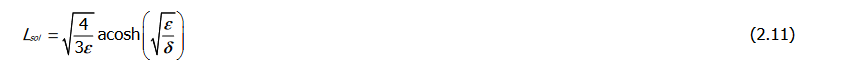

In [130]:
# Input parameters
epsilons = np.array([0.1, 0.2, 0.4])
g = 9.81 #[m/s^2], gravity
d0 = 1 #[m], still water depth
num_times = 5

# Print values
print("Initial water depth: {:.2f}".format(d0))
print("Number of times: {}".format(num_times))

Initial water depth: 1.00
Number of times: 5


In [131]:
# Model parameters
# The model domain length and simulation time also change with the incident wave height

L_sol = calc_L_scaling(epsilons, delta_scaling=1/20) # Length of the solitary wave
L_channel = 100 * L_sol                             # Length of the domain
x0s = -2 * L_sol                                     # Initial x-offset
# x0s = -10 * L_sol                                     # Initial x-offset

c = calc_wave_speed(g, epsilons, d0)

print("Scaling wave lengths: {}".format(L_sol))
print("Channel Lengths: {}".format(L_channel))
print("x0 Locations: {}".format(x0s))
print("Wave speed: {}".format(c))

Scaling wave lengths: [7.95392551 5.62427466 3.97696275]
Channel Lengths: [795.39255065 562.42746627 397.69627532]
x0 Locations: [-15.90785101 -11.24854933  -7.95392551]
Wave speed: [3.2841662  3.42785092 3.69407874]


In [132]:
simulation_times = 104 * L_sol/c # Simulation time so that the wave has enough time to make it across the entire domain

# Init list to hold the times
times = [0] * len(simulation_times)

# Loop over the total simualtion times and store those
for i, t in enumerate(simulation_times):

    # Loop over each total simulation time and generate the array
    times[i] = np.linspace(0, t, num_times)

In [133]:
# Model domain paramters
num_wave_gridpoint = 160      # Number of grid points per wave length
dx = L_sol/num_wave_gridpoint # x-increment
num_grid_point = L_channel[0]/dx[0]

# Init list to hold the grids
grids = [0] * len(epsilons)

# Grid points
grid = np.linspace(0, L_channel[0], int(num_grid_point) )

print("Num Grid points: {}".format(num_grid_point))

Num Grid points: 15999.999999999998


### Calc the first solution

### Plot the solution

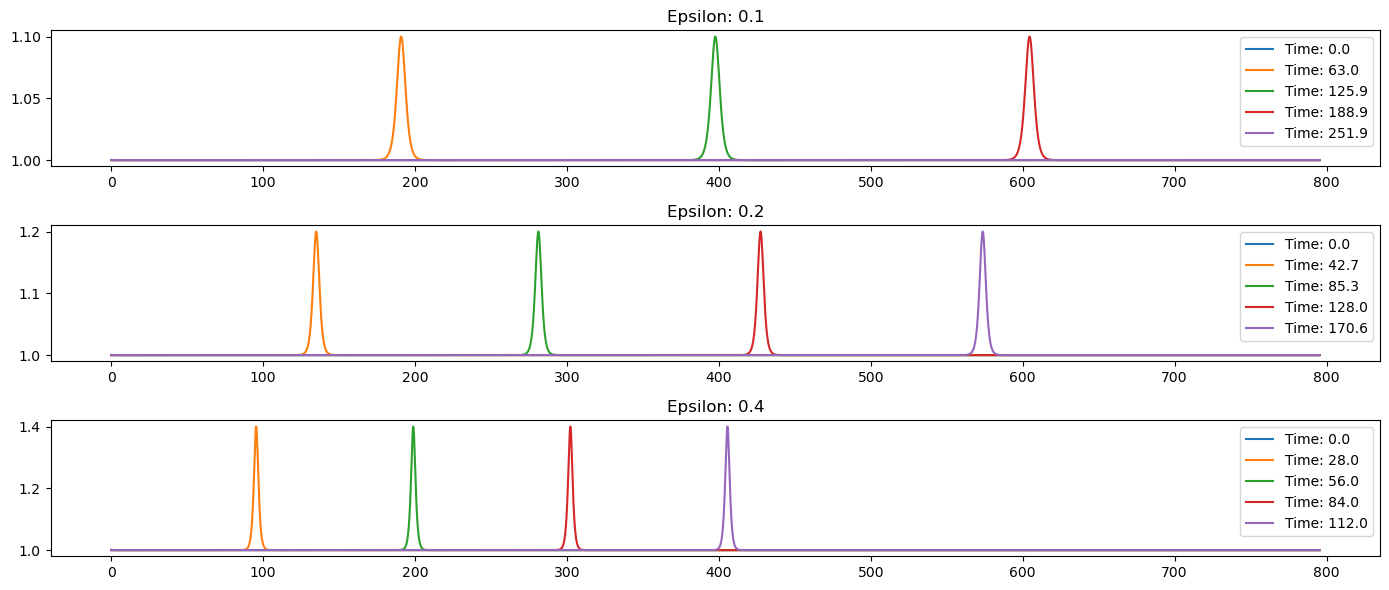

In [134]:
fig, axs = plt.subplots( ncols = 1, nrows = 3, figsize = (14, 6) )

# Loop over the epsilon values and iterate through the plots
for index, e in enumerate(epsilons):
    time = times[index]

    # Loop over the times and plot the solution at different times
    for j, t in enumerate(time):
        # Calc the solution of the domain
        eta = calc_surface_elevation(e, x0s[index], grid, t, g, d0)

        axs[index].set_title("Epsilon: {}".format(e))
        # Plot the result
        axs[index].plot(grid, eta, label = "Time: {}".format(t.round(1)))

    # axs[index].set_ylim([1, 1.45])
    axs[index].legend()

plt.tight_layout()
plt.show()

### Calc the velocities at the water surface

In [135]:
# Set the index for the current wave
index = 0

# Select the first epsilon
epsilon = epsilons[index]

# Select the time arr
time = np.linspace(0, times[index][-1], 1000)

# Select the initial x0 location
x0 = x0s[index]

x_location = 0.0
# Calc the x velocity
u_vel = calc_u_vel(epsilon, x0 = x0, x = x_location, y = d0, t = time, g = g, d0 = d0)

# Calc the y velocity
v_vel = calc_v_vel(epsilon, x0 = x0, x = x_location, y = d0, t = time, g = g, d0 = d0)

# Calc the water surface elevation
eta = calc_surface_elevation(epsilon, x0, x= x_location, t = time, g = g, d0 = d0)

# Calc the average u velocity
u_avg = calc_depth_average_u(epsilon, x0, x = x_location, t = time, g = g, d0 = d0)

In [136]:
# Check that the depth averaged velocity makes sense

num_locations = 100
y_locations = np.linspace(0, d0, num_locations)

u_sum = 0
for y in y_locations:
    # Calc the velocity
    u_vel = calc_u_vel(epsilon, x0 = x0, x = x_location, y = y, t = time, g = g, d0 = d0)

    # Sum the velocities
    u_sum += u_vel

# Average the velocities
u_avg_calc = u_sum/num_locations


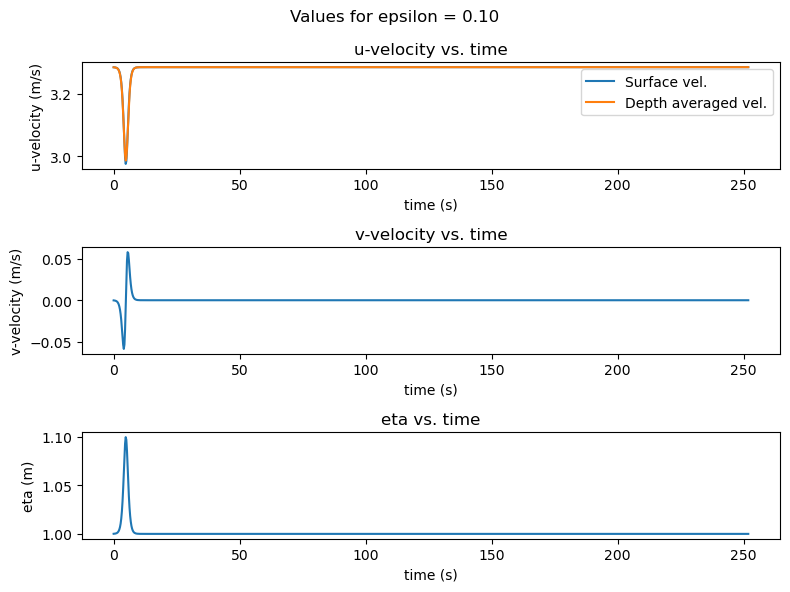

In [137]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 6))

axs[0].plot(time, u_vel, label = "Surface vel.")
axs[0].plot(time, u_avg, label = "Depth averaged vel.")
axs[1].plot(time, v_vel)
axs[2].plot(time, eta)

# Plot the depth averaged velocity
# Label the plots
plt.suptitle("Values for epsilon = {:.2f}".format(epsilon))

axs[0].set_title("u-velocity vs. time")
axs[0].set_xlabel("time (s)")
axs[0].set_ylabel("u-velocity (m/s)")
axs[0].legend()

axs[1].set_title("v-velocity vs. time")
axs[1].set_xlabel("time (s)")
axs[1].set_ylabel("v-velocity (m/s)")

axs[2].set_title("eta vs. time")
axs[2].set_xlabel("time (s)")
axs[2].set_ylabel("eta (m)")

plt.tight_layout()
plt.show()

### Creating the wbctype = ts_nonh file

There should only be one node in the vertical if I'm thinking about this right. So for the time being 
I'm going to consider it to be that way and then work from there. It's possible that there's two nodes one on the water surface and one at the bottom. Putting one at the bottom would be kind of dumb though (so I don't think they did it).


In [138]:
# Load in the sim1 time series
sim1_time_series = pd.read_csv(filepath_or_buffer= r"C:\ERDC\Liz_simulations\sim1_time_data.csv", header= None)

# Convert the time series to an arr
sim1_time_series = np.array(sim1_time_series.iloc[:, 0])

eta_sim1 = calc_surface_elevation(epsilon, x0, x= x_location, t = sim1_time_series, g = g, d0 = d0)

C:\Users\johnm\AppData\Local\Temp\ipykernel_3808\4171596191.py:26: RuntimeWarning: overflow encountered in cosh
  return 1/np.cosh(x)


In [139]:
# Stack U, V, and eta slices column-wise
data = np.column_stack((time, u_avg, eta - 1))
# data = np.column_stack((sim1_time_series, eta_sim1 -1 ))

folder_path = r'C:\ERDC\Liz_simulations\24_sol_wave_nx_26000_tstop_40_CFL_075' 

# This file name is required by xBeach
file_name = r'boun_U.bcf'
# file_name = "test.csv"

file_path = os.path.join(folder_path, file_name)

write_bcf = True

if write_bcf:
    # Write the header and the data to a file
    with open(file_path, 'w') as file:
        file.write("vector\n")
        file.write("3\n")
        file.write("t U Z\n")
        np.savetxt(file, data, delimiter=' ', fmt='%10.10f')


    print("Data written to {}".format(file_path))

Data written to C:\ERDC\Liz_simulations\24_sol_wave_nx_26000_tstop_40_CFL_075\boun_U.bcf
